Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/master/LICENSE.md)


# Building a scan programatically

In this notebook we'll build up a scan definition from first principles, against a local model trained within the
notebook.  We will then run that scan and save its results.  Finally we will extract the scan defintion as YAML, which could be used to run the same scan (potentially on revised models or datasets) via the Certifai stand-alone scanner.

In [1]:
import pandas as pd
import pprint
import matplotlib as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from copy import copy

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.common.utils.encoding import CatEncoder

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer.fit(data[0])
    return Pipeline(steps=[('imputer', imputer), ('model', model)])

svm_model = build_model((encoder(X_train.values), y_train),
                        'Support Vector Machine',
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        'Logistic classifier',
                        'logistic',
                        test=(encoder(X_test.values), y_test))

Model 'Support Vector Machine' accuracy is 0.77
Model 'Logistic classifier' accuracy is 0.77


In [3]:
# Wrap the model up for use by Certifai as a local model
svm_model_proxy = CertifaiPredictorWrapper(svm_model, encoder=encoder)
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)

In [4]:
def dropout(d, p=0.):
    vals = d.values
    mask = np.random.binomial(1, p=p, size=vals.shape)
    vals[mask==1] = np.nan
    return pd.DataFrame(vals, columns=d.columns)

all_df = pd.read_csv(all_data_file)
temp_df = dropout(all_df, p=0.1)

temp_df.to_csv('temp_nulled.csv', index=False)
temp_df = pd.read_csv('temp_nulled.csv')
display(temp_df)

,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,...,property,age,otherplans,housing,cards,job,liable,telephone,foreign,outcome
0,NaN,6.00,critical account/ other credits existing (not ...,car (new),1343.00,... < 100 DM,.. >= 7 years,nan,male : single,others - none,...,NaN,> 25 years,NaN,own,2.00,skilled employee / official,2.00,phone - none,foreign - no,1.00
1,... < 0 DM,28.00,existing credits paid back duly till now,car (new),4006.00,... < 100 DM,1 <= ... < 4 years,3.00,male : single,others - none,...,"car or other, not in attribute 6",> 25 years,none,own,1.00,unskilled - resident,1.00,NaN,foreign - yes,2.00
2,no checking account,nan,existing credits paid back duly till now,radio/television,2284.00,... < 100 DM,4 <= ... < 7 years,4.00,male : single,others - none,...,"car or other, not in attribute 6",> 25 years,none,own,1.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",foreign - yes,1.00
3,NaN,24.00,NaN,radio/television,1533.00,... < 100 DM,... < 1 year,4.00,female : divorced/separated/married,others - none,...,"car or other, not in attribute 6",> 25 years,stores,own,1.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",foreign - yes,1.00
4,no checking account,12.00,existing credits paid back duly till now,car (new),1101.00,... < 100 DM,1 <= ... < 4 years,3.00,male : married/widowed,NaN,...,real estate,NaN,none,own,2.00,NaN,1.00,NaN,foreign - yes,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,... < 0 DM,18.00,all credits at this bank paid back duly,furniture/equipment,1553.00,... < 100 DM,1 <= ... < 4 years,4.00,male : single,others - none,...,"car or other, not in attribute 6",> 25 years,bank,own,nan,skilled employee / official,1.00,phone - none,foreign - yes,2.00
996,no checking account,24.00,critical account/ other credits existing (not ...,radio/television,1851.00,... < 100 DM,4 <= ... < 7 years,4.00,NaN,guarantor,...,"car or other, not in attribute 6",> 25 years,none,own,2.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",foreign - yes,1.00
997,no checking account,nan,NaN,furniture/equipment,3349.00,... < 100 DM,NaN,4.00,female : divorced/separated/married,others - none,...,"car or other, not in attribute 6",> 25 years,none,own,1.00,management/ self-employed/highly qualified emp...,1.00,"phone - yes, registered under the customers name",foreign - yes,2.00
998,... >= 200 DM / salary assignments for at leas...,36.00,existing credits paid back duly till now,radio/television,4210.00,... < 100 DM,1 <= ... < 4 years,4.00,male : single,NaN,...,"car or other, not in attribute 6",> 25 years,none,own,1.00,skilled employee / official,1.00,phone - none,foreign - yes,2.00


In [5]:
# Create the scan object from scratch using the ScanBuilder class

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_use_case',
                                  prediction_task=task)

# Add our local models
# first_model = CertifaiModel('SVM',
#                             local_predictor=svm_model_proxy)
# scan.add_model(first_model)
second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv('temp_nulled.csv'))
scan.add_dataset(eval_dataset)
# Add the explanation dataset
expl_dataset = CertifaiDataset('explanation',
                               CertifaiDatasetSource.dataframe(temp_df[:20]))
scan.add_dataset(expl_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_evaluation_type('explainability')
scan.add_evaluation_type('explanation')
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'
scan.explanation_dataset_id = 'explanation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Optionally, you can change the path that reports are written to
# scan.output_path = '../local_reports'

In [6]:
# Run a preflight scan
# The preflight scan will run various checks against each model to alert about possible situations
# that may impact your scan, as well as produce a time estimate for your scan. A preflight report
# will be written per model that contains various data from the preflight scan, which will be
# used to offer time estimates when running future scans.
preflight_result = scan.run_preflight()

# The result is a dictionary of dictionaries of observations from the preflight scan. The top
# level dict key is the model id and the second level is the type of observation (e.g. messages, warnings, errors)
pprint.pprint(preflight_result)

2020-11-17 09:38:12,215 root   ERROR    Error processing key: 'cf_seeding' in section: 'algo_hyper_params': Unknown dtype 'NoneType' specified
Traceback (most recent call last):
  File "/Users/sdraper/projects/certifai/certifai_common/certifai/common/utils/utils.py", line 236, in get_config
    return _get_by_config(config, key, section, dtype)
  File "/Users/sdraper/projects/certifai/certifai_common/certifai/common/utils/utils.py", line 221, in _get_by_config
    raise ValueError(f"Unknown dtype '{dtype}' specified")
ValueError: Unknown dtype 'NoneType' specified
2020-11-17 09:38:12,225 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for status='male : divorced/separated' with 46 samples)


Starting Preflight Scan
[--------------------] 2020-11-17 09:38:12.163446 - 0 of 4 checks (0.0% complete) - Running model nondeterminism preflight check for model logistic
[#####---------------] 2020-11-17 09:38:12.213534 - 1 of 4 checks (25.0% complete) - Running scan time estimate preflight check for model logistic
[##########----------] 2020-11-17 09:39:43.245890 - 2 of 4 checks (50.0% complete) - Running unknown outcome class preflight check for model logistic
[###############-----] 2020-11-17 09:39:43.250595 - 3 of 4 checks (75.0% complete) - Running fairness class samples preflight check for model logistic
[####################] 2020-11-17 09:39:43.252283 - 4 of 4 checks (100.0% complete) - Finished all preflight checks for model logistic
{'logistic': {'errors': [],
              'messages': ['Passed model non determinism check',
                           'Expected time for explainability analysis is 93 '
                           'seconds',
                           'Expected

In [7]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)

2020-11-17 09:39:43,326 root   ERROR    Error processing key: 'cf_seeding' in section: 'algo_hyper_params': Unknown dtype 'NoneType' specified
Traceback (most recent call last):
  File "/Users/sdraper/projects/certifai/certifai_common/certifai/common/utils/utils.py", line 236, in get_config
    return _get_by_config(config, key, section, dtype)
  File "/Users/sdraper/projects/certifai/certifai_common/certifai/common/utils/utils.py", line 221, in _get_by_config
    raise ValueError(f"Unknown dtype '{dtype}' specified")
ValueError: Unknown dtype 'NoneType' specified


Starting scan with model_use_case_id: 'test_use_case' and scan_id: '2eeadf7b44bd', total estimated time is 7 minutes
[--------------------] 2020-11-17 09:39:43.326263 - 0 of 3 reports (0.0% complete) - Running explainability evaluation for model: logistic, estimated time is 93 seconds


2020-11-17 09:41:19,229 root   ERROR    Error processing key: 'cf_seeding' in section: 'algo_hyper_params': Unknown dtype 'NoneType' specified
Traceback (most recent call last):
  File "/Users/sdraper/projects/certifai/certifai_common/certifai/common/utils/utils.py", line 236, in get_config
    return _get_by_config(config, key, section, dtype)
  File "/Users/sdraper/projects/certifai/certifai_common/certifai/common/utils/utils.py", line 221, in _get_by_config
    raise ValueError(f"Unknown dtype '{dtype}' specified")
ValueError: Unknown dtype 'NoneType' specified


[######--------------] 2020-11-17 09:41:19.228387 - 1 of 3 reports (33.33% complete) - Running explanation evaluation for model: logistic, estimated time is 23 seconds


2020-11-17 09:41:38,843 root   ERROR    Error processing key: 'cf_seeding' in section: 'algo_hyper_params': Unknown dtype 'NoneType' specified
Traceback (most recent call last):
  File "/Users/sdraper/projects/certifai/certifai_common/certifai/common/utils/utils.py", line 236, in get_config
    return _get_by_config(config, key, section, dtype)
  File "/Users/sdraper/projects/certifai/certifai_common/certifai/common/utils/utils.py", line 221, in _get_by_config
    raise ValueError(f"Unknown dtype '{dtype}' specified")
ValueError: Unknown dtype 'NoneType' specified
2020-11-17 09:41:38,853 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for status='male : divorced/separated' with 46 samples)


[#############-------] 2020-11-17 09:41:38.842806 - 2 of 3 reports (66.67% complete) - Running fairness evaluation for model: logistic, estimated time is 259 seconds


2020-11-17 09:42:25,962 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 46 samples
2020-11-17 09:42:44,384 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 82 samples
2020-11-17 09:43:22,481 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 173 samples
2020-11-17 09:43:41,821 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 279 samples
2020-11-17 09:43:53,728 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 724 samples
2020-11-17 09:43:53,729 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 498 samples


[####################] 2020-11-17 09:44:01.572934 - 3 of 3 reports (100.0% complete) - Completed all evaluations


In [8]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible
print(type(result['fairness']['logistic']['fairness']['secondary_scores']))
df = construct_scores_dataframe(scores('fairness', result), include_confidence=False)
display(df)

<class 'list'>


,context,type in [],fairness,Feature (age),type in Feature (age),Group details (<= 25 years),type in Feature (age),Group details (> 25 years),Feature (status),type in Feature (status),Group details (female : divorced/separated/married),type in Feature (status),Group details (male : divorced/separated),type in Feature (status),Group details (male : married/widowed),type in Feature (status),Group details (male : single)
logistic (burden),logistic,burden,65.84,66.16,burden,0.07,burden,0.04,76.58,burden,0.06,burden,0.05,burden,0.03,burden,0.03


,context,type in [],fairness,fairness lower bound,fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,type in Feature (age),Group details (<= 25 years),...,Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,type in Feature (status),Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,type in Feature (status),Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
logistic (burden),logistic,burden,65.84,55.72,75.59,66.16,55.83,77.44,burden,0.07,...,0.03,0.07,burden,0.03,0.02,0.04,burden,0.03,0.03,0.04


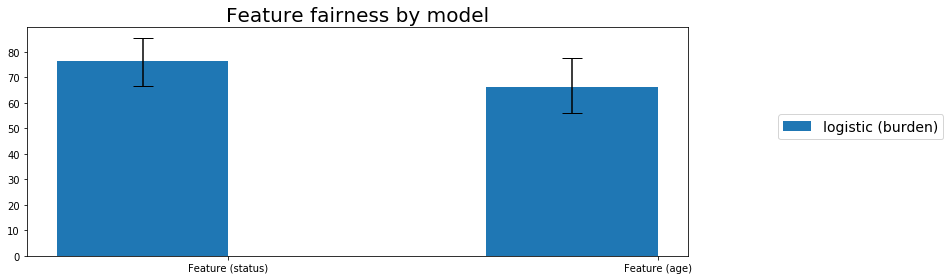

In [9]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))

display(df)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

In [10]:

from certifai.scanner.explanation_utils import explanations, construct_explanations_dataframe, counterfactual_changes

pd.set_option('display.max_columns', None)

# Using Certifai's explanation utilities we can programmatically explore counterfactuals produced
# during the explanation evaluation. Below we examine only a single explanation for each model
# by displaying the original input data followed by what features were changed by each
# counterfactual. Note, that for this regression use case a counterfactual will produced in the
# favorable direction (increasing) and in the unfavorable direction (decreasing)
logistic_explanations = construct_explanations_dataframe(explanations(result, model_id='logistic'))


def display_explanation(df):
    df_original = df[df['instance']=='original']
    display(df_original)
    changes = counterfactual_changes(df)
    display(changes)

print("Explanations for logistic Model:\n")
for row in range(1, 21):
    display_explanation(logistic_explanations[logistic_explanations['row'] == row]) 


Explanations for logistic Model:



,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
0,logistic,1,original,0,original prediction,1,0.00,nan,6.00,critical account/ other credits existing (not ...,car (new),1343.00,... < 100 DM,.. >= 7 years,nan,male : single,others - none,4.00,nan,> 25 years,nan,own,2.00,skilled employee / official,2.00,phone - none,foreign - no


,instance,cf_num,cf_type,prediction,fitness,history,status
0,original,0,original prediction,1,0.00,critical account/ other credits existing (not ...,male : single
0,counterfactual,1,prediction changed,2,0.50,all credits at this bank paid back duly,male : married/widowed


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
2,logistic,2,original,0,original prediction,2,0.00,... < 0 DM,28.00,existing credits paid back duly till now,car (new),4006.00,... < 100 DM,1 <= ... < 4 years,3.00,male : single,others - none,2.00,"car or other, not in attribute 6",> 25 years,none,own,1.00,unskilled - resident,1.00,nan,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,savings
0,original,0,original prediction,2,0.00,... < 100 DM
0,counterfactual,1,prediction changed,1,1.00,.. >= 1000 DM


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
4,logistic,3,original,0,original prediction,1,0.00,no checking account,nan,existing credits paid back duly till now,radio/television,2284.00,... < 100 DM,4 <= ... < 7 years,4.00,male : single,others - none,2.00,"car or other, not in attribute 6",> 25 years,none,own,1.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,employ,others
0,original,0,original prediction,1,0.00,no checking account,4 <= ... < 7 years,others - none
0,counterfactual,1,prediction changed,2,0.33,... < 0 DM,... < 1 year,co-applicant


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
6,logistic,4,original,0,original prediction,1,0.00,nan,24.00,nan,radio/television,1533.00,... < 100 DM,... < 1 year,4.00,female : divorced/separated/married,others - none,3.00,"car or other, not in attribute 6",> 25 years,stores,own,1.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,housing
0,original,0,original prediction,1,0.00,own
0,counterfactual,1,prediction changed,2,1.00,rent


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
8,logistic,5,original,0,original prediction,1,0.00,no checking account,12.00,existing credits paid back duly till now,car (new),1101.00,... < 100 DM,1 <= ... < 4 years,3.00,male : married/widowed,nan,2.00,real estate,nan,none,own,2.00,nan,1.00,nan,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus
0,original,0,original prediction,1,0.00,no checking account
0,counterfactual,1,prediction changed,2,1.00,... < 0 DM


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
10,logistic,6,original,0,original prediction,1,0.00,no checking account,60.00,critical account/ other credits existing (not ...,car (new),13756.00,unknown/ no savings account,.. >= 7 years,2.00,male : single,others - none,4.00,unknown / no property,nan,bank,nan,1.00,management/ self-employed/highly qualified emp...,1.00,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,history
0,original,0,original prediction,1,0.00,critical account/ other credits existing (not ...
0,counterfactual,1,prediction changed,2,1.00,all credits at this bank paid back duly


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
12,logistic,7,original,0,original prediction,1,0.00,... < 0 DM,6.00,critical account/ other credits existing (not ...,car (new),4716.00,unknown/ no savings account,... < 1 year,1.00,male : single,others - none,3.00,real estate,nan,none,own,2.00,unskilled - resident,2.00,phone - none,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,history,installment
0,original,0,original prediction,1,0.00,critical account/ other credits existing (not ...,1.00
0,counterfactual,1,prediction changed,2,0.53,all credits at this bank paid back duly,1.89


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
14,logistic,8,original,0,original prediction,1,0.00,... >= 200 DM / salary assignments for at leas...,12.00,existing credits paid back duly till now,radio/television,1881.00,... < 100 DM,1 <= ... < 4 years,2.00,female : divorced/separated/married,others - none,2.00,"car or other, not in attribute 6",> 25 years,none,rent,1.00,unskilled - resident,1.00,nan,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,history,cards
0,original,0,original prediction,1,0.00,... >= 200 DM / salary assignments for at leas...,existing credits paid back duly till now,1.00
0,counterfactual,1,prediction changed,2,0.49,0 <= ... < 200 DM,all credits at this bank paid back duly,1.02


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
16,logistic,9,original,0,original prediction,1,0.00,nan,24.00,nan,car (new),2032.00,... < 100 DM,.. >= 7 years,nan,male : single,others - none,4.00,unknown / no property,> 25 years,none,for free,2.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus
0,original,0,original prediction,1,0.00,nan
0,counterfactual,1,prediction changed,2,1.00,... < 0 DM


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
18,logistic,10,original,0,original prediction,1,0.00,no checking account,36.00,existing credits paid back duly till now,car (new),3079.00,nan,1 <= ... < 4 years,4.00,male : single,others - none,4.00,real estate,> 25 years,none,own,1.00,skilled employee / official,1.00,phone - none,nan


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,history
0,original,0,original prediction,1,0.00,no checking account,existing credits paid back duly till now
0,counterfactual,1,prediction changed,2,0.50,... < 0 DM,no credits taken/ all credits paid back duly


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
20,logistic,11,original,0,original prediction,1,0.00,no checking account,6.00,critical account/ other credits existing (not ...,nan,1382.00,... < 100 DM,1 <= ... < 4 years,1.00,female : divorced/separated/married,others - none,nan,"car or other, not in attribute 6",> 25 years,none,own,2.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",nan


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,history,purpose,otherplans
0,original,0,original prediction,1,0.00,no checking account,critical account/ other credits existing (not ...,nan,none
0,counterfactual,1,prediction changed,2,0.25,... < 0 DM,all credits at this bank paid back duly,education,bank


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
22,logistic,12,original,0,original prediction,1,0.00,nan,12.00,nan,business,nan,... < 100 DM,nan,4.00,female : divorced/separated/married,others - none,1.00,real estate,> 25 years,none,nan,1.00,unemployed/ unskilled - non-resident,1.00,phone - none,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,liable
0,original,0,original prediction,1,0.00,nan,1.00
0,counterfactual,1,prediction changed,2,0.78,... < 0 DM,1.10


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
24,logistic,13,original,0,original prediction,1,0.00,0 <= ... < 200 DM,12.00,existing credits paid back duly till now,furniture/equipment,983.00,.. >= 1000 DM,... < 1 year,1.00,female : divorced/separated/married,others - none,4.00,real estate,<= 25 years,none,rent,1.00,unskilled - resident,1.00,phone - none,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,history,savings,liable
0,original,0,original prediction,1,0.00,existing credits paid back duly till now,.. >= 1000 DM,1.00
0,counterfactual,1,prediction changed,2,0.49,all credits at this bank paid back duly,... < 100 DM,1.01


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
26,logistic,14,original,0,original prediction,1,0.00,0 <= ... < 200 DM,18.00,nan,furniture/equipment,6361.00,... < 100 DM,.. >= 7 years,2.00,male : single,nan,1.00,unknown / no property,> 25 years,nan,own,1.00,nan,1.00,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,status
0,original,0,original prediction,1,0.00,male : single
0,counterfactual,1,prediction changed,2,1.00,male : divorced/separated


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
28,logistic,15,original,0,original prediction,1,0.00,no checking account,21.00,critical account/ other credits existing (not ...,furniture/equipment,2288.00,... < 100 DM,... < 1 year,4.00,female : divorced/separated/married,others - none,4.00,building society savings agreement/ life insur...,<= 25 years,nan,own,1.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus
0,original,0,original prediction,1,0.00,no checking account
0,counterfactual,1,prediction changed,2,1.00,... < 0 DM


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
30,logistic,16,original,0,original prediction,1,0.00,0 <= ... < 200 DM,42.00,critical account/ other credits existing (not ...,business,nan,... < 100 DM,4 <= ... < 7 years,2.00,female : divorced/separated/married,others - none,nan,real estate,> 25 years,bank,own,2.00,unskilled - resident,1.00,phone - none,nan


,instance,cf_num,cf_type,prediction,fitness,history,installment
0,original,0,original prediction,1,0.00,critical account/ other credits existing (not ...,2.00
0,counterfactual,1,prediction changed,2,0.67,all credits at this bank paid back duly,2.49


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
32,logistic,17,original,0,original prediction,1,0.00,no checking account,18.00,existing credits paid back duly till now,furniture/equipment,2515.00,... < 100 DM,1 <= ... < 4 years,3.00,male : single,others - none,4.00,real estate,> 25 years,none,own,1.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",nan


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,history,status
0,original,0,original prediction,1,0.00,no checking account,existing credits paid back duly till now,male : single
0,counterfactual,1,prediction changed,2,0.33,... < 0 DM,all credits at this bank paid back duly,male : divorced/separated


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
34,logistic,18,original,0,original prediction,1,0.00,no checking account,11.00,existing credits paid back duly till now,business,2142.00,.. >= 1000 DM,.. >= 7 years,1.00,male : divorced/separated,others - none,2.00,real estate,> 25 years,none,nan,1.00,nan,1.00,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,purpose,amount,savings,installment,property,cards,liable
0,original,0,original prediction,1,0.00,no checking account,11.00,business,2142.00,.. >= 1000 DM,1.00,real estate,1.00,1.00
0,counterfactual,1,prediction changed,2,0.19,... < 0 DM,10.62,education,2413.74,... < 100 DM,1.70,unknown / no property,1.15,1.03


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
36,logistic,19,original,0,original prediction,1,0.00,0 <= ... < 200 DM,9.00,critical account/ other credits existing (not ...,radio/television,1154.00,... < 100 DM,nan,2.00,male : single,others - none,4.00,real estate,> 25 years,none,own,3.00,nan,1.00,phone - none,nan


,instance,cf_num,cf_type,prediction,fitness,history,purpose,installment,status
0,original,0,original prediction,1,0.00,critical account/ other credits existing (not ...,radio/television,2.00,male : single
0,counterfactual,1,prediction changed,2,0.30,all credits at this bank paid back duly,car (new),2.28,male : divorced/separated


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
38,logistic,20,original,0,original prediction,1,0.00,0 <= ... < 200 DM,24.00,existing credits paid back duly till now,radio/television,2039.00,... < 100 DM,... < 1 year,1.00,nan,others - none,1.00,building society savings agreement/ life insur...,<= 25 years,none,own,1.00,skilled employee / official,1.00,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,purpose,installment
0,original,0,original prediction,1,0.00,radio/television,1.00
0,counterfactual,1,prediction changed,2,0.58,car (new),1.71


,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
logistic,logistic,88.71,43.75,0.00,36.72,13.28,2.34,3.91,0.00,0.00,0.00,0.00


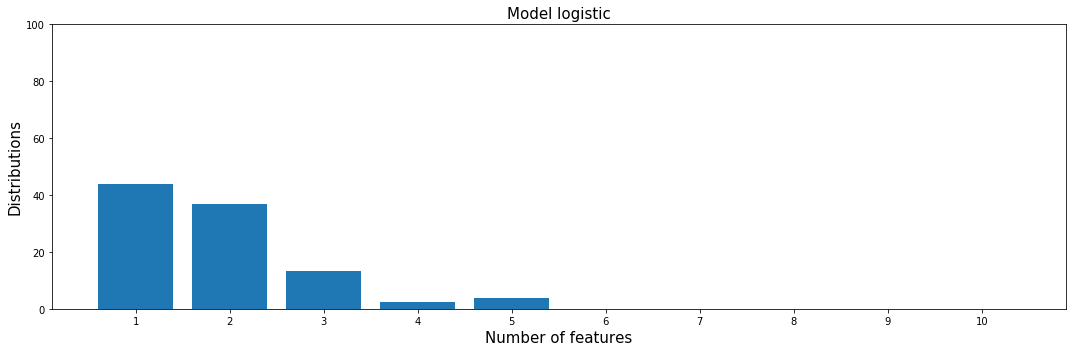

In [11]:
explainability_df = construct_scores_dataframe(scores('explainability', result))
display(explainability_df)

%matplotlib inline

def plot_histogram(axs, explainability_df, model_id):
    num_features = list(range(1, 11))
    columns = [f"Num features ({i})" for i in num_features]
    percentages = explainability_df.loc[model_id, columns].values
    
    axs.bar(num_features, percentages)
    axs.set_xticks(num_features)
    axs.set_xlabel('Number of features', fontsize=15)
    axs.set_title(f"Model {model_id}", fontsize=15)
    axs.set_ylabel('Distributions', fontsize=15)
    axs.set_ylim(top=100)

def plot_explainability_histograms(explainability_df):
    labels = explainability_df['context'].values
    
    fig, axes = plt.subplots(1, 1, figsize=[15,5])
#     fig.suptitle('Explainability results by model', fontsize=20)
    
    plot_histogram(axes, explainability_df, labels[0])
    
    fig.tight_layout()
    plt.show()
    
plot_explainability_histograms(explainability_df)